## Importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error as MSE, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
import joblib

## Loading the training dataset

In [2]:
train = pd.read_csv('../input/black-friday-sales-prediction/train_oSwQCTC (1)/train.csv')
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


## Understanding and examining the structure and organization of the dataset

In [3]:
train.shape

(550068, 12)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [5]:
train.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [6]:
train[train.duplicated()]

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase


## Data Cleaning & Preprocessing

In [7]:
train.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [8]:
train['Product_Category_2'].fillna(train['Product_Category_2'].mean(),inplace=True)
train['Product_Category_3'].fillna(train['Product_Category_3'].mode()[0],inplace=True)

In [9]:
## Discarding the unique identification features such as "User ID" and "Product ID" which aren't of any use in modeling purposes.
train.drop(['User_ID','Product_ID'],axis=1,inplace=True)

In [10]:
train['Gender'].value_counts()

M    414259
F    135809
Name: Gender, dtype: int64

In [11]:
train['Gender'].replace(['M','F'],[1,0],inplace=True)
train['Gender'] = train['Gender'].astype(int)

## Exploratory Data Analysis

<AxesSubplot:>

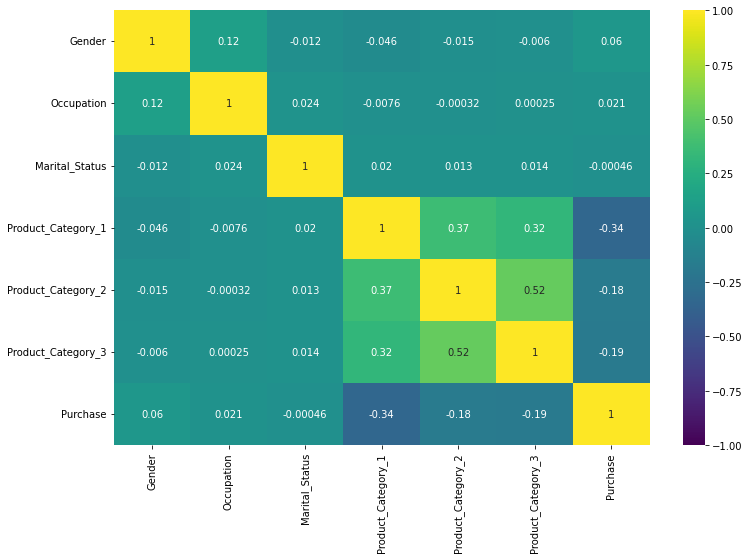

In [12]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(),annot=True,cmap='viridis',vmin=-1,vmax=1)

The feature "Product_Category_1" has mildly negative correlation with total purchase amount.

<AxesSubplot:xlabel='Age', ylabel='count'>

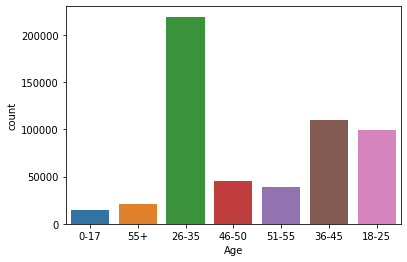

In [13]:
sns.countplot(train['Age'])

Majority of the customers belong to the age group of 26-35 years.

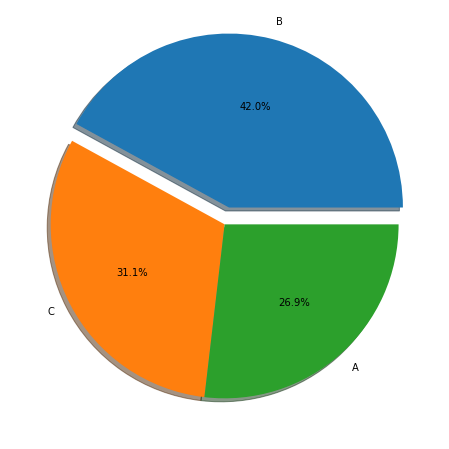

In [14]:
plt.figure(figsize=(12,8))
values = train['City_Category'].value_counts().values
labels = train['City_Category'].value_counts().keys()
explode = (0.1,0,0)
plt.pie(values,labels=labels,explode=explode,shadow=True,autopct='%1.1f%%');

## Categorical Encoding

In [15]:
train['Stay_In_Current_City_Years'].replace('4+','4',inplace=True)

In [16]:
train['Stay_In_Current_City_Years'] = train['Stay_In_Current_City_Years'].astype(int)

In [17]:
city_categories = {'A': 1, 'B': 2, 'C': 3}
train['City_Category'] = train['City_Category'].map(city_categories)
train['City_Category'].head()

0    1
1    1
2    1
3    1
4    3
Name: City_Category, dtype: int64

In [18]:
train['City_Category'] = train['City_Category'].astype(int)

In [19]:
le = LabelEncoder()
train['Age'] = le.fit_transform(train['Age'])
train['Age'] = train['Age'].astype(int)
train['Age'].dtypes

dtype('int64')

## Loading the test dataset

In [20]:
test = pd.read_csv('../input/black-friday-sales-prediction/test_HujdGe7 (1)/test.csv')
test_c = test.copy()
test.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,NaN
3,1000010,P00145342,F,36-45,1,B,4+,1,4,9.0,NaN
4,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0


## Cleaning and transforming the test dataset into the desired form

In [21]:
test.drop(['User_ID','Product_ID'],axis=1,inplace=True)

In [22]:
test['Gender'].replace(['M','F'],[1,0],inplace=True)
test['Gender'] = test['Gender'].astype(int)
test['Age'] = le.fit_transform(test['Age'])
test['Age'] = test['Age'].astype(int)
test['City_Category'] = test['City_Category'].map(city_categories)
test['City_Category'] = test['City_Category'].astype(int)
test['Stay_In_Current_City_Years'].replace('4+','4',inplace=True)
test['Stay_In_Current_City_Years'] = test['Stay_In_Current_City_Years'].astype(int)
test['Product_Category_2'].fillna(test['Product_Category_2'].mean(),inplace=True)
test['Product_Category_3'].fillna(test['Product_Category_3'].mean(),inplace=True)

## Performing feature scaling along with splitting of the dataset into training and testing sets..

In [23]:
X = train.drop('Purchase',axis=1)
y = train['Purchase']
scaler = StandardScaler()
features = X.columns
scaled_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X,columns=features)
X_train, X_test, y_train, y_test = train_test_split(scaled_X,y,test_size=0.2,random_state=1)

# Model Training & Evaluation

## Linear Regression

In [24]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [25]:
lr.score(X_test,y_test)

0.13247521594346157

## XG Boost Regressor

In [26]:
xgb = XGBRegressor()
xgb.fit(X_train.values,y_train.values)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [27]:
xgb.score(X_test.values,y_test.values)

0.6733773379986892

In [28]:
xgb_pred = xgb.predict(X_test.values)
print('RMSE:',np.sqrt(MSE(y_test,xgb_pred)))
print("R2 Score:",r2_score(y_test,xgb_pred))

RMSE: 2876.0486988784783
R2 Score: 0.6733773379986892


In [29]:
xgb = cross_val_score(xgb,X_train,y_train,cv=5)
print(xgb)
print('Mean Score:',np.mean(xgb))

[0.66697353 0.6706295  0.67024394 0.67336298 0.66994266]
Mean Score: 0.6702305224619639


## K Nearest Neighbors Regressor

In [30]:
knn = KNeighborsRegressor()
knn.fit(X_train.values,y_train.values)

KNeighborsRegressor()

In [31]:
knn.score(X_test.values,y_test.values)

0.5225057760128313

In [32]:
knn_pred = knn.predict(X_test.values)
print('RMSE:',np.sqrt(MSE(y_test,knn_pred)))
print("R2 Score:",r2_score(y_test,knn_pred))

RMSE: 3477.419937089273
R2 Score: 0.5225057760128313


## Extra Trees Regressor

In [33]:
et = ExtraTreesRegressor()
et.fit(X_train.values,y_train.values)

ExtraTreesRegressor()

In [34]:
et.score(X_test.values,y_test.values)

0.6068499556893932

In [35]:
et_pred = et.predict(X_test.values)
print('RMSE:',np.sqrt(MSE(y_test,et_pred)))
print("R2 Score:",r2_score(y_test,et_pred))

RMSE: 3155.3841738637193
R2 Score: 0.6068499556893932


## Bagging Regressor

In [36]:
bag = BaggingRegressor()
bag.fit(X_train.values,y_train.values)

BaggingRegressor()

In [37]:
bag.score(X_test.values,y_test.values)

0.6256566210838141

In [38]:
bag_pred = bag.predict(X_test.values)
print('RMSE:',np.sqrt(MSE(y_test,bag_pred)))
print("R2 Score:",r2_score(y_test,bag_pred))

RMSE: 3078.9891359580724
R2 Score: 0.6256566210838141


## Random Forest Regressor

In [39]:
rfc = RandomForestRegressor()
rfc.fit(X_train,y_train)

RandomForestRegressor()

In [40]:
rfc.score(X_test,y_test)

0.6348589258703337

In [41]:
rfc_pred = rfc.predict(X_test)
print('RMSE:',np.sqrt(MSE(y_test,rfc_pred)))
print('R2 Score:',r2_score(y_test,rfc_pred))

RMSE: 3040.9089923697697
R2 Score: 0.6348589258703337


## Decision Tree Regressor

In [42]:
dtree = DecisionTreeRegressor()
dtree.fit(X_train,y_train)

DecisionTreeRegressor()

In [43]:
dtree.score(X_test,y_test)

0.569428017740284

In [44]:
dtree_pred = dtree.predict(X_test)
print('RMSE:',np.sqrt(MSE(y_test,dtree_pred)))
print('R2 Score:',r2_score(y_test,dtree_pred))

RMSE: 3302.1436474575703
R2 Score: 0.569428017740284


## Gradient Boosting Regressor

In [45]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train.values,y_train.values)

GradientBoostingRegressor()

In [46]:
gbr.score(X_test.values,y_test.values)

0.6489995043744484

In [47]:
gbr_pred = gbr.predict(X_test)
print('RMSE:',np.sqrt(MSE(y_test,gbr_pred)))
print('R2 Score:',r2_score(y_test,gbr_pred))

RMSE: 2981.44596931474
R2 Score: 0.6489995043744484


## Cat Boost Regressor

In [48]:
cat = CatBoostRegressor()
cat.fit(X_train.values,y_train.values)

Learning rate set to 0.107116
0:	learn: 4743.0522203	total: 137ms	remaining: 2m 16s
1:	learn: 4501.1106138	total: 195ms	remaining: 1m 37s
2:	learn: 4321.6101433	total: 256ms	remaining: 1m 24s
3:	learn: 4145.9074080	total: 313ms	remaining: 1m 17s
4:	learn: 4008.4481560	total: 371ms	remaining: 1m 13s
5:	learn: 3887.2753858	total: 427ms	remaining: 1m 10s
6:	learn: 3783.6452664	total: 488ms	remaining: 1m 9s
7:	learn: 3705.8112027	total: 551ms	remaining: 1m 8s
8:	learn: 3607.8631720	total: 604ms	remaining: 1m 6s
9:	learn: 3544.6323630	total: 666ms	remaining: 1m 5s
10:	learn: 3496.2578249	total: 722ms	remaining: 1m 4s
11:	learn: 3455.3412649	total: 783ms	remaining: 1m 4s
12:	learn: 3420.2328938	total: 835ms	remaining: 1m 3s
13:	learn: 3385.1770048	total: 895ms	remaining: 1m 3s
14:	learn: 3360.7288019	total: 944ms	remaining: 1m 2s
15:	learn: 3306.3892195	total: 1000ms	remaining: 1m 1s
16:	learn: 3264.8940644	total: 1.05s	remaining: 1m
17:	learn: 3245.6541377	total: 1.11s	remaining: 1m
18:	lea

In [49]:
cat.score(X_test.values,y_test.values)

0.6734526523886544

In [50]:
cat_pred = cat.predict(X_test)
print('RMSE:',np.sqrt(MSE(y_test,cat_pred)))
print('R2 Score:',r2_score(y_test,cat_pred))

RMSE: 2875.717092461418
R2 Score: 0.6734526523886544


## Light Gradient Boosting Regressor

In [51]:
lgbm = LGBMRegressor()
lgbm.fit(X_train.values,y_train.values)

LGBMRegressor()

In [52]:
lgbm.score(X_test.values,y_test.values)

0.6657688316482868

In [53]:
lgbm_pred = lgbm.predict(X_test)
print('RMSE:',np.sqrt(MSE(y_test,lgbm_pred)))
print('R2 Score:',r2_score(y_test,lgbm_pred))

RMSE: 2909.3538937063017
R2 Score: 0.6657688316482868


## Multi-Layer Perceptron Model

In [54]:
mlp = MLPRegressor(hidden_layer_sizes=(128,),activation='relu',batch_size=32,solver='adam')
mlp.fit(X_train.values,y_train.values)

MLPRegressor(batch_size=32, hidden_layer_sizes=(128,))

In [55]:
mlp.score(X_test.values,y_test.values)

0.42575271256004876

In [56]:
mlp_pred = mlp.predict(X_test)
print('RMSE:',np.sqrt(MSE(y_test,mlp_pred)))
print('R2 Score:',r2_score(y_test,mlp_pred))

RMSE: 3813.489497684278
R2 Score: 0.42575271256004876


## Stochastic Gradient Descent Regressor

In [57]:
sgd = SGDRegressor()
sgd.fit(X_train.values,y_train.values)

SGDRegressor()

In [58]:
sgd.score(X_test.values,y_test.values)

0.13205799812659025

In [59]:
sgd_pred = sgd.predict(X_test)
print('RMSE:',np.sqrt(MSE(y_test,sgd_pred)))
print('R2 Score:',r2_score(y_test,sgd_pred))

RMSE: 4688.332787450086
R2 Score: 0.13205799812659025


## Establishing the final dataframe with the model predictions

In [60]:
df = pd.concat([pd.DataFrame(xgb_pred),test_c['User_ID'],test_c['Product_ID']],axis=1)
df.head()

,0,User_ID,Product_ID
0,7302.432129,1000004,P00128942
1,2064.596191,1000009,P00113442
2,5374.159180,1000010,P00288442
3,7453.087402,1000010,P00145342
4,13199.101562,1000011,P00053842


In [61]:
df.shape

(233599, 3)

In [62]:
df.to_csv('submission.csv')

## Saving XGBoost Model for Deployment

In [63]:
joblib.dump(xgb,'model.pkl')

['model.pkl']

In [64]:
joblib.load('model.pkl')

array([0.66697353, 0.6706295 , 0.67024394, 0.67336298, 0.66994266])